# Image Classification using ResNet



Introduction

Install keras and other relevant packages

In [ ]:
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
from keras.utils import to_categorical
import pandas as pd
from PIL import Image

2.3.0


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling3D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.callbacks import EarlyStopping, Callback
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras
from keras import backend as K 

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=1988966836699603d86b21164efe3a48df47c864dfba886dd11b7b253b69646e
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=2b0a331a0e64e0ce8c5a98d25be9576cc31347830f6395f03164e7597f552485
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
!pip install plotly --upgrade 
!pip install h5py

     |████████████████████████████████| 13.1MB 200kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import h5py
from kerastuner.tuners import RandomSearch
from kerastuner.applications import HyperResNet
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from kerastuner import HyperModel
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import IPython

Connecting google drive to access files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this creates a symbolic link so that now the path /content/drive/My\ Drive/ is equal to /mydrive
!ln -s /content/drive/My\ Drive/ /mydrive
#!ls /mydrive

Importing input data 

In [ ]:
#main dataset
data = np.load("/mydrive/Image_classification/data/input_data.npz")


In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data['a'], data['b'], data['c'], data['d'],data['e'],data['f']

In [ ]:
x_train = preprocess_input(x_train)
x_valid = preprocess_input(x_valid )
x_test = preprocess_input(x_test)

In [ ]:
vocab, inv = np.unique(y_train, return_inverse=True)
y_train = to_categorical(inv)

In [ ]:
vocab, inv = np.unique(y_valid, return_inverse=True)
y_valid = to_categorical(inv)

In [ ]:
vocab, inv = np.unique(y_test, return_inverse=True)
y_test = to_categorical(inv)

In [ ]:
resnet50model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


##Tuning Model With One Additional Hidden Layer

In [ ]:
#Setting up model architecture and hyperparameters to tune

class CNNHyperModel(HyperModel):
    def __init__(self, classes):
        self.num_classes = classes

    def build(self, hp):
        x = resnet50model.output
        
        
        x = GlobalAveragePooling2D()(x) 
        x = Dense(
              units=hp.Int(
                    'units_1',
                    min_value=64,
                    max_value=256,
                    step=64,
                    default=128),
            activation='relu')(x)

        x = Dropout(rate=hp.Float(
                'dropout',
                min_value=0.0,
                max_value=0.6,
                default=0.2,
                step=0.2,
            ))(x)

        predictions = Dense(self.num_classes, activation='softmax')(x)

        # creating the final model 
        model = Model(inputs = resnet50model.input, outputs = predictions)

        # Making only the last four layers trainable

        # To reduce the Number of parameters that feed to future FC layer which 
        # reduce the total weights and can improve training speed

        for layer in model.layers[:-4]:
            layer.trainable = False

        # compile the model 
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4]
                          )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
class ClearTrainingOutput(Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
#setting up tuner, and directory to save output

hypermodel = CNNHyperModel(classes=2)

tuner = Hyperband(
    hypermodel,
    tune_new_entries=True,
    objective='val_accuracy',
    max_epochs = 10,
    seed= 23,
    directory='/mydrive/Image_classification/tuning',
    project_name='prey_hyperband')


INFO:tensorflow:Reloading Oracle from existing project /mydrive/Image_classification/tuning/prey_hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /mydrive/Image_classification/tuning/prey_hyperband/tuner0.json


In [ ]:
#summary
tuner.search_space_summary()

### Search

In [ ]:
tuner.search(x_train, y_train,
             epochs = 10,
             validation_data=(x_valid, y_valid), 
             callbacks = [ClearTrainingOutput(), 
                          EarlyStopping('val_loss', patience=5), 
                          ModelCheckpoint(
                              filepath='/mydrive/Image_classification/tuning/model_tuner_weights/model.{epoch:02d}-{val_loss:.2f}.h5'), 
                          TensorBoard('/mydrive/Image_classification/tuning/tuner_history')])

INFO:tensorflow:Oracle triggered exit


### Outcome of Search

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'dropout': 0.4,
 'learning_rate': 0.01,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_1': 256}

### Rebuilding Model

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.get_best_models(num_models=1)[0]

In [ ]:
my_callbacks = [
    EarlyStopping('val_accuracy', patience=10),
    ModelCheckpoint(
        filepath='/mydrive/Image_classification/models/training/model.{epoch:02d}-{val_accuracy:.2f}.h5'),
]

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, epochs = 50, validation_data = (x_valid, y_valid), callbacks=my_callbacks)

Epoch 1/50
147/147 [==============================] - 20s 137ms/step - loss: 0.1213 - accuracy: 0.9510 - val_loss: 0.5378 - val_accuracy: 0.8029
Epoch 2/50
147/147 [==============================] - 18s 124ms/step - loss: 0.0934 - accuracy: 0.9631 - val_loss: 0.4048 - val_accuracy: 0.8557
Epoch 3/50
147/147 [==============================] - 18s 126ms/step - loss: 0.1045 - accuracy: 0.9623 - val_loss: 0.5175 - val_accuracy: 0.8282
Epoch 4/50
147/147 [==============================] - 19s 129ms/step - loss: 0.0938 - accuracy: 0.9631 - val_loss: 0.4887 - val_accuracy: 0.8414
Epoch 5/50
147/147 [==============================] - 20s 133ms/step - loss: 0.0742 - accuracy: 0.9717 - val_loss: 0.3700 - val_accuracy: 0.8656
Epoch 6/50
147/147 [==============================] - 19s 131ms/step - loss: 0.0756 - accuracy: 0.9695 - val_loss: 0.5935 - val_accuracy: 0.8535
Epoch 7/50
147/147 [==============================] - 19s 129ms/step - loss: 0.0680 - accuracy: 0.9734 - val_loss: 0.4524 - val_ac

In [ ]:
model.load_weights('/mydrive/Image_classification/models/training/model.23-0.90.h5')

In [ ]:
model.save("/mydrive/Image_classification/models/best_one_layer_model.h5")

In [ ]:
model = tf.keras.models.load_model("/mydrive/Image_classification/models/best_one_layer_model.h5")

### Results on Validation Set

In [ ]:
loss, accuracy = model.evaluate(x_valid, y_valid)
loss, accuracy

29/29 [==============================] - 3s 101ms/step - loss: 0.4574 - accuracy: 0.8954


(0.4573519825935364, 0.8953744769096375)

In [ ]:
valid_pred = model.predict(x_valid)
val_pred_classes = np.argmax(valid_pred,axis=1)

In [ ]:
correct_values = np.argmax(y_valid,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(val_pred_classes,correct_values)*100

89.53744493392071

In [ ]:
con_matrix = confusion_matrix(val_pred_classes,correct_values)
con_matrix

array([[387,  51],
       [ 44, 426]])

In [ ]:
def performance_measures(y_pred, y_true):
  """
  Outputs the and specificity of a binary classification prediction model
  Inputs:
    y_pred (list) - predictions from model  
    y_true (list) - true classes of dataset
  Output:
   recall, precision (tuple) - the recall, precision of the model
  """
  confusion = confusion_matrix(y_pred, y_true)
  TP = confusion[1,1]
  FN = confusion[0,1]
  FP = confusion[1,0]

  recall = TP/(TP+FN)
  precision = TP/(TP+FP)

  return recall, precision

In [ ]:
recall, precision = performance_measures(val_pred_classes, correct_values)
print(recall, precision)

0.8930817610062893 0.9063829787234042


In [ ]:
#calculating F1 score 
f1_score = 2*precision*recall/(precision+recall)
f1_score

0.8996832101372756

Visualisation of Training History

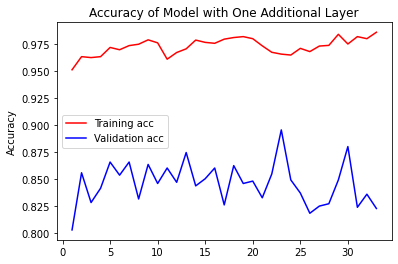

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylabel("Accuracy")
plt.title('Accuracy of Model with One Additional Layer')
plt.legend()
plt.savefig('/mydrive/Image_classification/results/image_outputs/accuracy1.png')
plt.show()

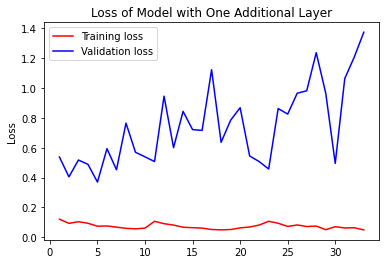

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel("Loss")
plt.title('Loss of Model with One Additional Layer')
plt.legend()
plt.savefig('/mydrive/Image_classification/results/image_outputs/loss1.png')
plt.show()

##Tuning Model With Two Additional Hidden Layers

In [ ]:
class CNNHyperModel1(HyperModel):
    def __init__(self, classes):
        self.num_classes = classes

    def build(self, hp):
        x = resnet50model.output
        
        # To reduce the Number of parameters that feed to future FC layer which 
         # reduce the total weights and can improve training speed
        x = GlobalAveragePooling2D()(x) 
        x = Dense(
              units=hp.Int(
                    'units',
                    min_value=64,
                    max_value=256,
                    step=64,
                    default=128),
            activation='relu')(x)

        x = Dropout(rate=hp.Float(   # Regularization method to minimize overfitting
                'dropout',
                min_value=0.0,
                max_value=0.6,
                default=0.2,
                step=0.2,
            ))(x)

        x = Dense(
              units=hp.Int(
                    'units_1',
                    min_value=64,
                    max_value=256,
                    step=64,
                    default=128),
            activation='relu')(x)


        x = Dropout(rate=hp.Float( 
                'dropout_1',
                min_value=0.0,
                max_value=0.6,
                default=0.2,
                step=0.2,
            ))(x) 
        

        predictions = Dense(self.num_classes, activation='softmax')(x)

        # creating the final model 
        model = Model(inputs = resnet50model.input, outputs = predictions)

        # Freezing first seven layers
        for layer in model.layers[:-6]:
            layer.trainable = False

        # compile the model 
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4]
                          )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
hypermodel1 = CNNHyperModel1(classes=2)


tuner1 = Hyperband(
    hypermodel1,
    tune_new_entries=True,
    objective='val_accuracy',
    max_epochs = 10,
    seed = 23,
    directory='/mydrive/Image_classification/tuning',
    project_name='prey_hyperband1',
    overwrite=False)


INFO:tensorflow:Reloading Oracle from existing project /mydrive/Image_classification/tuning/prey_hyperband1/oracle.json
INFO:tensorflow:Reloading Tuner from /mydrive/Image_classification/tuning/prey_hyperband1/tuner0.json


### Search

In [ ]:
tuner1.search_space_summary()

In [ ]:
tuner1.search(x_train, y_train,
             epochs=10,
             validation_data=(x_valid, y_valid), 
             callbacks = [ClearTrainingOutput(), 
                          EarlyStopping('val_loss', patience=5), 
                          TensorBoard('/mydrive/Image_classification/tuning/tuner1_history')])

INFO:tensorflow:Oracle triggered exit


### Outcome of Search

In [ ]:
tuner1.results_summary()

In [ ]:
best_hps1 = tuner1.get_best_hyperparameters(num_trials = 1)[0]
best_hps1.values

{'dropout': 0.6000000000000001,
 'dropout_1': 0.4,
 'learning_rate': 0.01,
 'tuner/bracket': 1,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units': 256,
 'units_1': 256}

### Rebuilding Model

In [ ]:
model1 = tuner1.get_best_models(num_models=1)[0]

In [ ]:
my_callbacks = [
    EarlyStopping('val_accuracy', patience=10),
    ModelCheckpoint(
        filepath='/mydrive/Image_classification/models/training/model1.{epoch:02d}-{val_accuracy:.2f}.h5'),
]

In [ ]:
history1 = model1.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), callbacks=my_callbacks)

Epoch 1/50
147/147 [==============================] - 20s 136ms/step - loss: 0.2444 - accuracy: 0.9084 - val_loss: 0.2922 - val_accuracy: 0.8910
Epoch 2/50
147/147 [==============================] - 19s 133ms/step - loss: 0.2293 - accuracy: 0.9203 - val_loss: 0.5429 - val_accuracy: 0.7720
Epoch 3/50
147/147 [==============================] - 19s 131ms/step - loss: 0.2202 - accuracy: 0.9220 - val_loss: 0.4776 - val_accuracy: 0.8315
Epoch 4/50
147/147 [==============================] - 19s 129ms/step - loss: 0.2108 - accuracy: 0.9216 - val_loss: 0.3814 - val_accuracy: 0.8370
Epoch 5/50
147/147 [==============================] - 19s 128ms/step - loss: 0.2134 - accuracy: 0.9231 - val_loss: 0.3047 - val_accuracy: 0.8711
Epoch 6/50
147/147 [==============================] - 19s 131ms/step - loss: 0.2448 - accuracy: 0.9229 - val_loss: 0.4529 - val_accuracy: 0.8513
Epoch 7/50
147/147 [==============================] - 19s 131ms/step - loss: 0.2447 - accuracy: 0.9237 - val_loss: 0.5506 - val_ac

In [ ]:
model1.load_weights('/mydrive/Image_classification/models/training/model1.10-0.90.h5')

In [ ]:
model1.save("/mydrive/Image_classification/models/best_two_layer_model.h5")

In [ ]:
model1 = tf.keras.models.load_model("/mydrive/Image_classification/models/best_two_layer_model.h5")

In [ ]:
one = np.reshape(x_valid[0], (1, x_valid[0].shape[0], x_valid[0].shape[1], x_valid[0].shape[2]))

In [ ]:
model1.predict(one)

array([[1.538984e-10, 1.000000e+00]], dtype=float32)

Visualisation of Training History

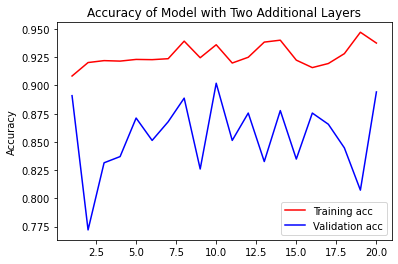

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylabel("Accuracy")
plt.title('Accuracy of Model with Two Additional Layers')
plt.legend()
plt.savefig('/mydrive/Image_classification/results/image_outputs/accuracy2.png')
plt.show()

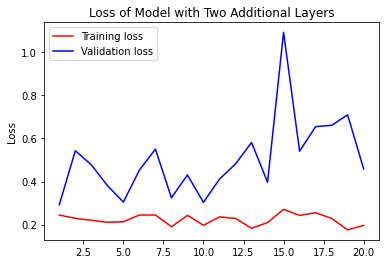

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylabel("Loss")
plt.title('Loss of Model with Two Additional Layers')
plt.legend()
plt.savefig('/mydrive/Image_classification/results/image_outputs/loss2.png')
plt.show()

### Results on Validation Set

In [ ]:
loss, accuracy = model1.evaluate(x_valid, y_valid)
loss, accuracy

29/29 [==============================] - 3s 94ms/step - loss: 0.3033 - accuracy: 0.9020


(0.3032894730567932, 0.9019823670387268)

In [ ]:
valid_pred1 = model1.predict(x_valid)
val_pred_classes1 = np.argmax(valid_pred1,axis=1)

In [ ]:
correct_values = np.argmax(y_valid,axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth : 1 while Prediction: 1')

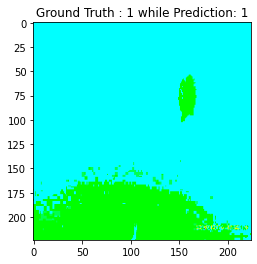

In [ ]:
plt.imshow( x_valid[0,:,:], cmap='gray')
plt.title("Ground Truth : {} while Prediction: {}".format(correct_values[0], val_pred_classes[0]))

In [ ]:
accuracy_score(val_pred_classes1,correct_values)*100

90.19823788546255

In [ ]:
con_matrix = confusion_matrix(val_pred_classes1,correct_values)
con_matrix

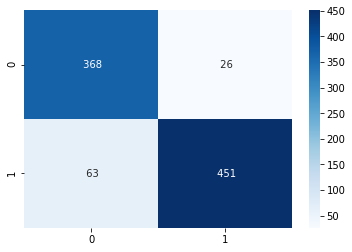

In [ ]:
#heatmap of confusion matrix
import seaborn as sns
sns.heatmap(con_matrix, annot=True, fmt=' ', cmap='Blues')

In [ ]:
recall, precision =performance_measures(val_pred_classes1,correct_values)
recall, precision

(0.9454926624737946, 0.877431906614786)

In [ ]:
f1_score = 2*precision*recall/(precision+recall)
f1_score

0.9101917255297678

## Select Final Model

Comparing the accuracy, recall, precision and f1-scores of the two re-built models. The model with two additional layers preformed better, and will be used going forward. 

In [ ]:
Data_file = pd.read_csv("/mydrive/Image_classification/data/Data_file.csv")

In [ ]:
Data_file[Data_file['split']=='validation'].head()

,Unnamed: 0,penguin_ID,Video_ID,Date,Time,Frame_No,Label,File_Name,split
682,682,GI-LP0237,MOVI0016,2016-10-18,13:22:45,1470,prey,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,validation
683,683,GI-LP0237,MOVI0016,2016-10-18,13:22:45,1471,prey,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,validation
684,684,GI-LP0237,MOVI0016,2016-10-18,13:22:45,1472,prey,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,validation
685,685,GI-LP0237,MOVI0016,2016-10-18,13:22:45,1473,prey,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,validation
686,686,GI-LP0237,MOVI0016,2016-10-18,13:22:45,1474,prey,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,validation


In [ ]:
valid_file = Data_file[Data_file['split']=='validation'][['File_Name','Label']]
valid_file["Correct_Label"] =  correct_values
valid_file["Predicted_Label"] =  val_pred_classes1
valid_file.head()

,File_Name,Label,Correct_Label,Predicted_Label
682,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,prey,1,1
683,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,prey,1,1
684,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,prey,1,1
685,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,prey,1,1
686,GI-LP0237_17_MOVI0016.avi_image_2016-10-18_13_...,prey,1,1


In [ ]:
wrong_predictions = valid_file[valid_file["Correct_Label"] != valid_file["Predicted_Label"]]
wrong_predictions.head()

,File_Name,Label,Correct_Label,Predicted_Label
1131,GI-LP0258_6_MOVI0005.avi_image_2016-10-23_07_3...,prey,1,0
1137,GI-LP0262_16_MOVI0015.avi_image_2016-11-22_11_...,prey,1,0
1138,GI-LP0262_16_MOVI0015.avi_image_2016-11-22_11_...,prey,1,0
1140,GI-LP0262_16_MOVI0015.avi_image_2016-11-22_11_...,prey,1,0
1142,GI-LP0262_16_MOVI0015.avi_image_2016-11-22_11_...,prey,1,0


In [ ]:
wrong_predictions.to_csv("/mydrive/Image_classification/results/wrong_predictions_valid.csv")